In [160]:
import torch 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pickle
import alu_dataset

from plain_net.PlainNet import PlainNet
from soft_thresholding.SoftThresholdNet import SoftThresholdNet
from L1_regularization.L1RegularizationNet import L1RegularizationNet
from dynamic_sparse_reparameterization.DynamicSparseReparameterizationNet import DynamicSparseReparameterizationNet
from magnitude_pruning.MagnitudePruning import MagnitudePruningNet

from utils import load_data, load_models

In [161]:
# Load data
dataset = "alu" # alu or duffing

# Load train and val data as dataloaders
train_loader, val_loader, test_loader = load_data(f"data/{dataset}")

# Load test data sets
with open("data/alu/test_data.pickle", "rb") as f:
    test_data = pickle.load(f)
    
dt = train_loader.dataset.DT

test_loader = DataLoader(alu_dataset.Dataset_alu(test_data, dt), shuffle=False)

y_std = test_loader.dataset.y_std
y_mean = test_loader.dataset.y_mean
x_std = test_loader.dataset.x_std
x_mean = test_loader.dataset.x_mean

In [162]:
test_set_n = 10
x_test = test_data[test_set_n]
t = torch.linspace(0, dt * len(x_test)/60/60, len(x_test))

In [163]:
path = "models/alu/L1_regularization/model" # plain, soft_thresholding, L1-regularization, dynamic_sparse_reparameterization, magnitude_pruning

models = load_models(path, n_models=1)

In [164]:
# Make predictions for each model
predictions = []
for model in models:
    prediction = torch.zeros_like(x_test).detach()
    prediction[:, 8:] = x_test[:, 8:]
    prediction[:1] = x_test[:1]
    predictions.append(prediction.detach())

    for i in range(1, len(prediction)):
        input = (prediction[i-1] - x_mean) / x_std
        x_dot = model(input) * y_std + y_mean
        prediction[i, :8] = prediction[i-1, :8] + x_dot * dt

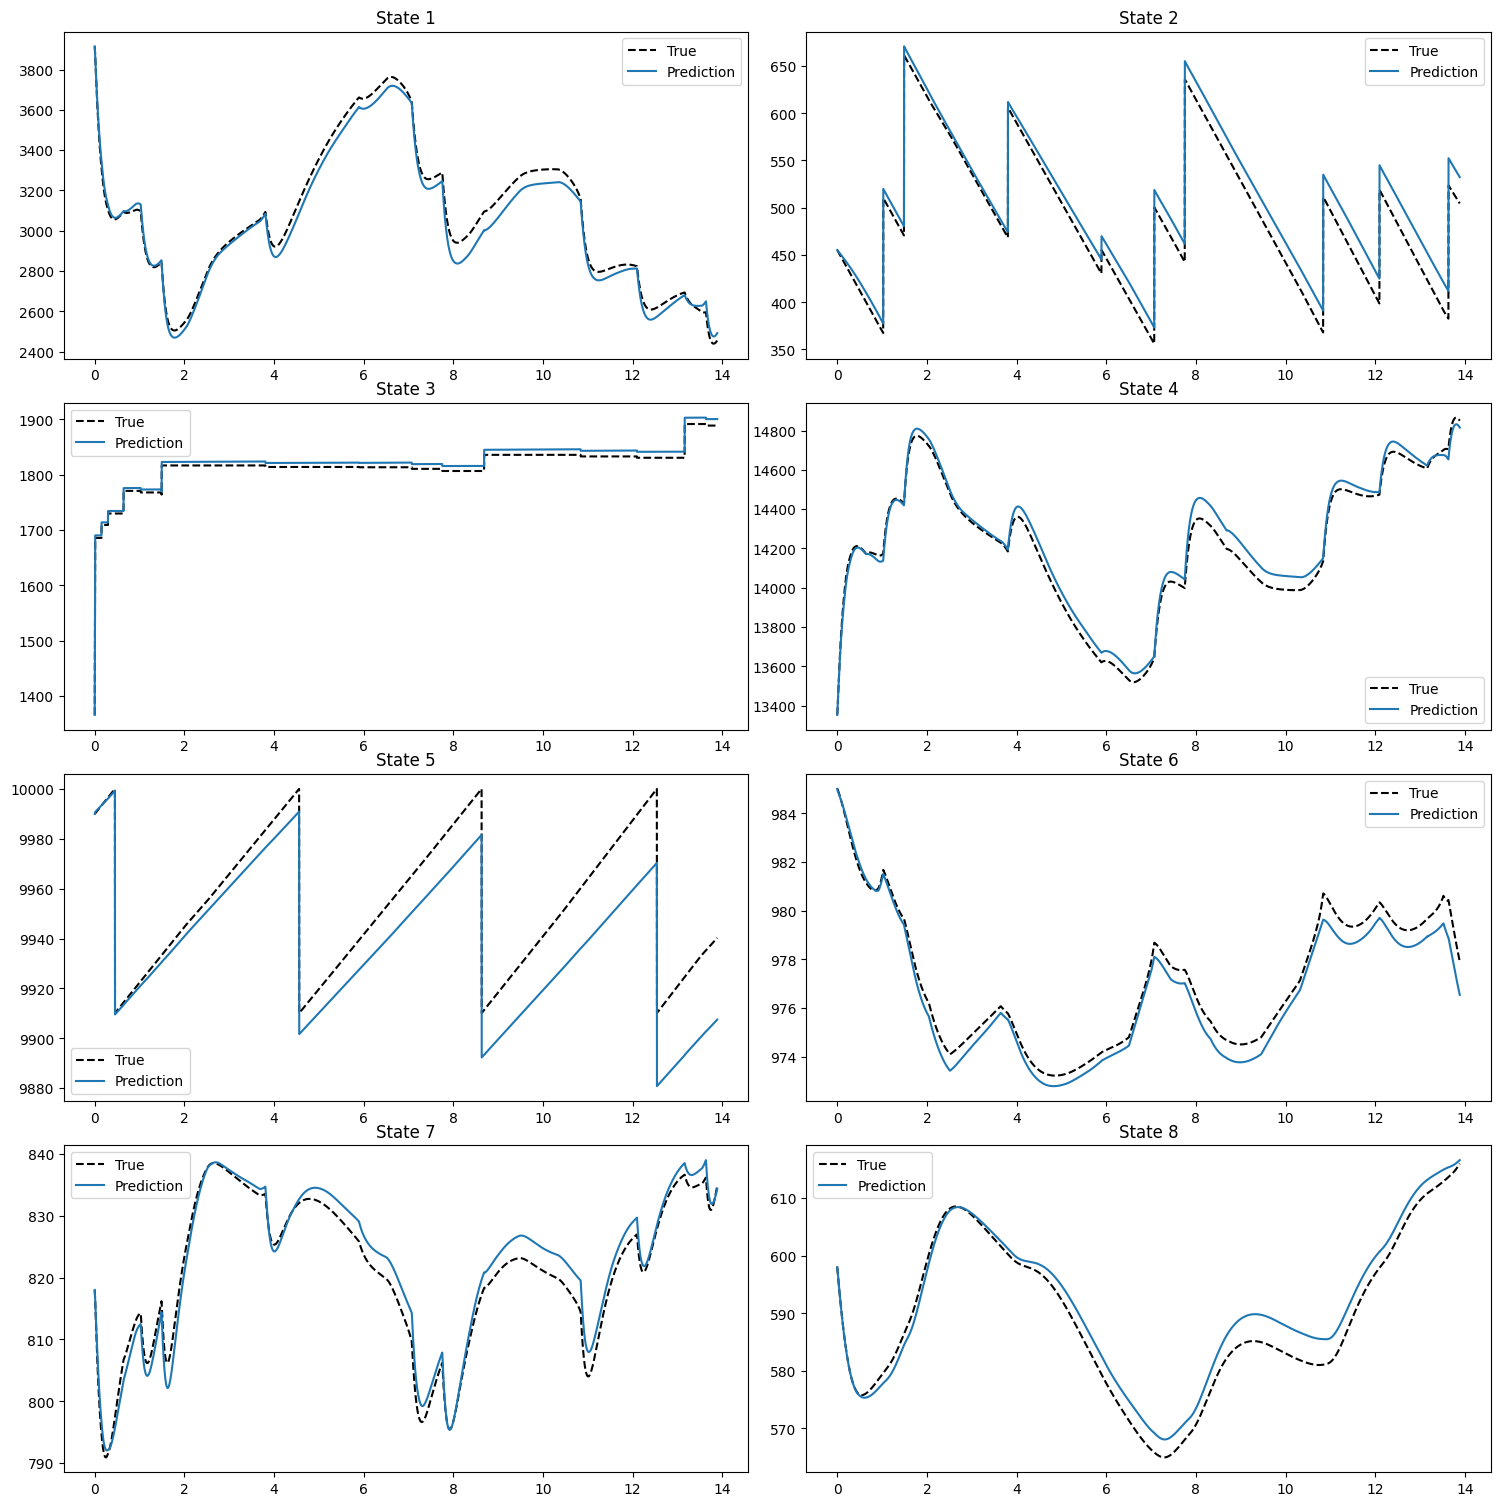

In [165]:
steps = 4999 # Max 4999
predictions = predictions[:5]

y_labels = ["$x_1$ [kg]", "x2 [kg]", "x3 [kg]", "x4 [kg]", "x5 [kg]", "x6 [C]", "x7 [C]", "x8 [C]"]
x_label = "Time [h]"

fig, ax = plt.subplots(4, 2, figsize=(15, 15))
fig.tight_layout()
for i in range(8):
    ax[i//2, i%2].plot(t[:steps], x_test[:steps, i], label="True", color="black", linestyle="--")
    for prediction in predictions:
        ax[i//2, i%2].plot(t[:steps], prediction[:steps, i].detach(), label="Prediction")
    ax[i//2, i%2].set_ylabel(y_labels[i])
    ax[i//2, i%2].set_xlabel(x_label)
    ax[i//2, i%2].set_title(f"State {i+1}")
    ax[i//2, i%2].legend()

In [166]:
mean_prediction = torch.zeros_like(x_test).detach()
for prediction in predictions:
    mean_prediction += prediction
mean_prediction /= len(predictions)

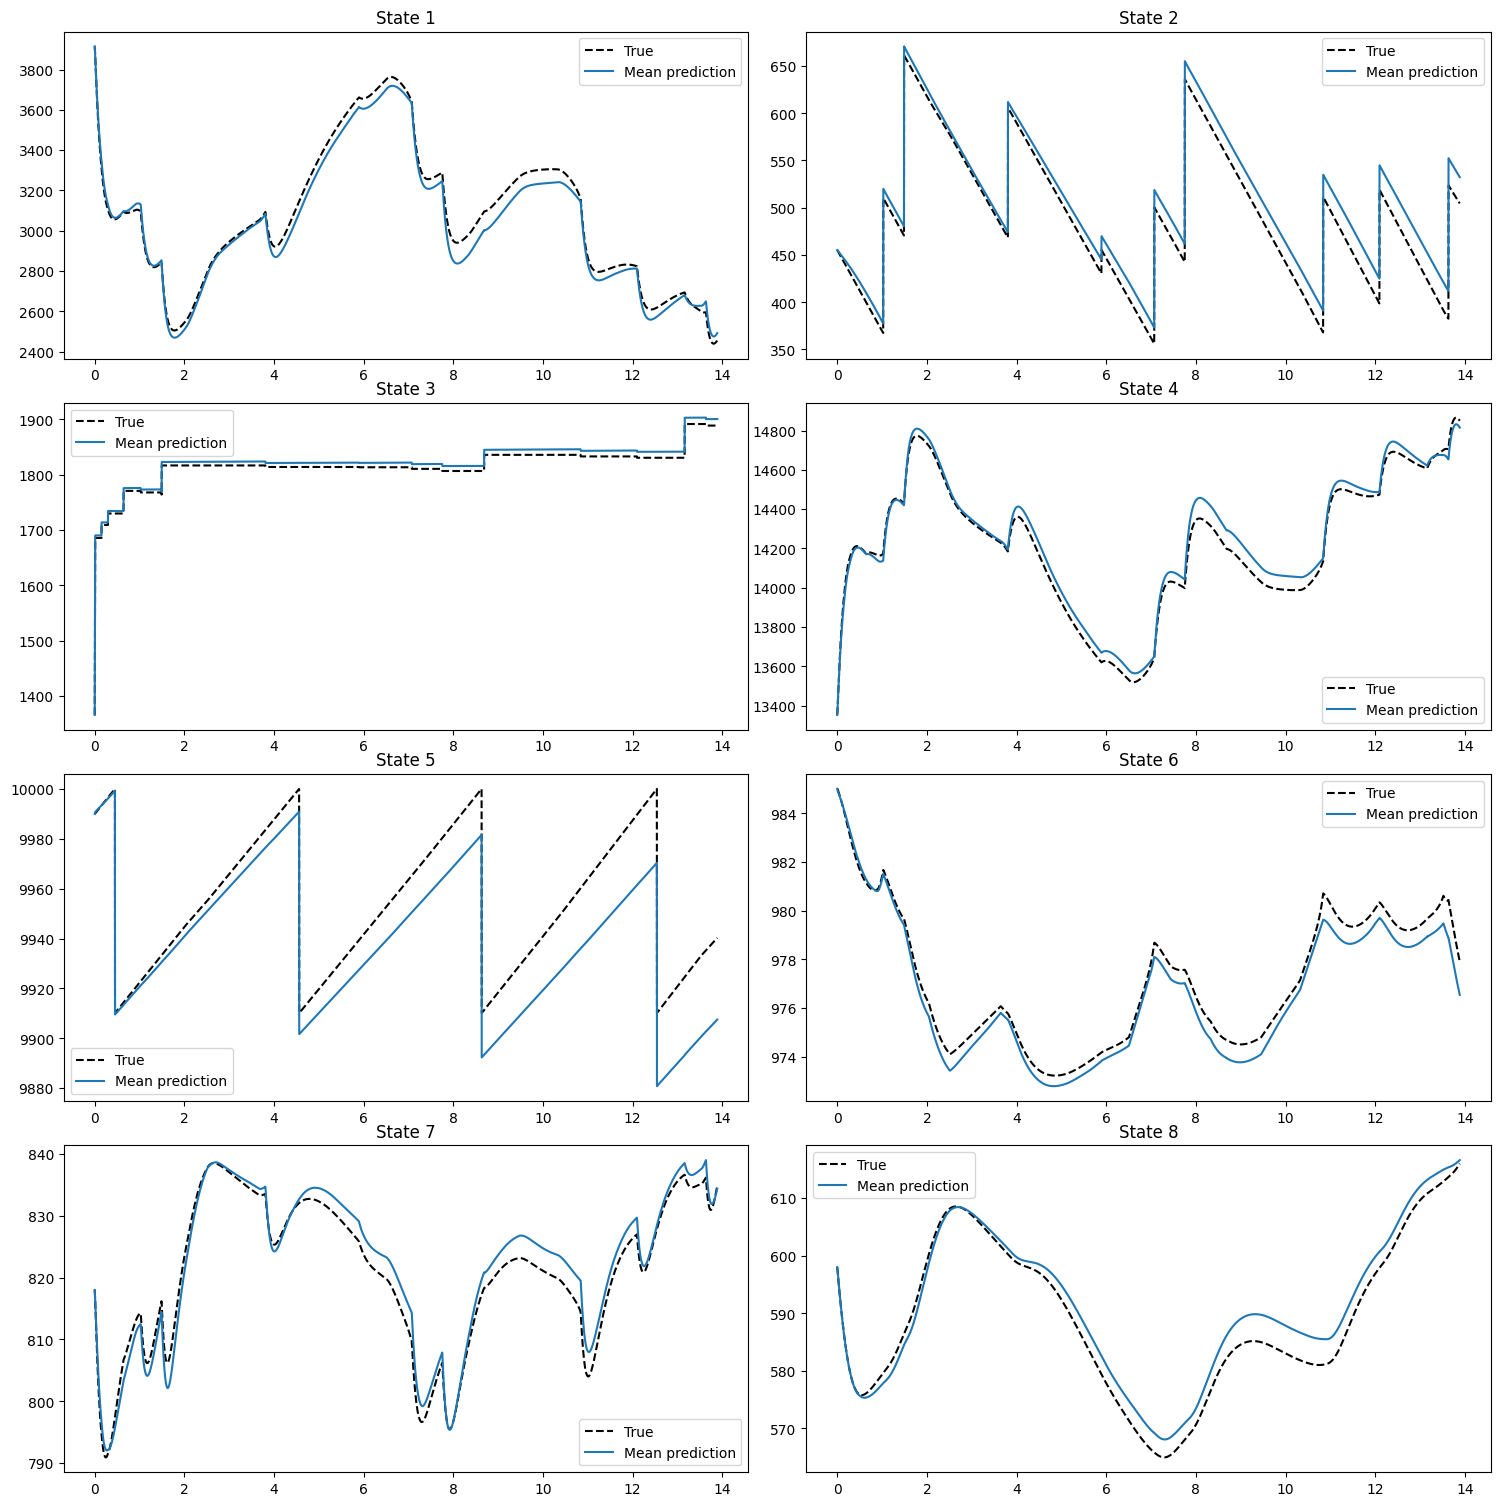

In [167]:
steps = 4999 # Max 4999

fig, ax = plt.subplots(4, 2, figsize=(15, 15))
fig.tight_layout()
for i in range(8):
    ax[i//2, i%2].plot(t[:steps], x_test[:steps, i], label="True", color="black", linestyle="--")
    ax[i//2, i%2].plot(t[:steps], mean_prediction[:steps, i].detach(), label="Mean prediction")
    ax[i//2, i%2].set_title(f"State {i+1}")
    ax[i//2, i%2].legend()